# Semantic Analysis of Presidential Speeches 

In this notebook we explore the idiosyncracies of different presidents semantic styles and complexity.


In [1]:
import sys
sys.path.append("c:\\Users\\robal\\Dropbox\\UChicago\\Year II\\Quarter II\\Computational Content Analysis\\final_project")

In [2]:
from ContentAnalysisPresidentialRhetoric.utils.utils import *
import lucem_illud
import pandas as pd
import matplotlib.pyplot as plt 
import wordcloud 
import numpy as np 
import scipy 
import seaborn as sns
import sklearn.manifold 
import json 

import spacy
# Import vader for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
SentimentScorer = SentimentIntensityAnalyzer()

#These are from the standard library
import matplotlib.pyplot as plt
import altair as alt

%matplotlib inline

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
speeches = pd.read_excel(r"../data/presidential_speeches.xlsx")
speeches.head()

,Unnamed: 0,President,Date,Speech
0,january-20-2021-inaugural-address,Joe Biden,"January 20, 2021","\n \n\n\n\n\n\nChief Justice Roberts, Vic..."
1,january-19-2021-farewell-address,Donald Trump,"January 19, 2021",\n \n\n\n\n\n\nMy fellow Americans: Four ...
2,january-13-2021-statement-about-violence-capitol,Donald Trump,"January 13, 2021","\n \n\n\n\n\n\nMy fellow Americans, \nI w..."
3,january-7-2021-message-after-pro-trump-mob-ove...,Donald Trump,"January 07, 2021",\n \n\n\n\n\n\nI would like to begin by a...
4,january-6-2021-speech-urging-supporters-go-home,Donald Trump,"January 06, 2021",\n \n\n\n\n\n\nI know your pain. I know y...


In [8]:
# Filter out JFK since we only have two speeches
speeches = speeches.loc[speeches.President != 'John F. Kennedy',:]

In [9]:
speeches.columns = ["speech_name", "President", "Date", "Speech"]
speeches["Speech"] = speeches.Speech.apply(lambda row: clean_raw_text([row])[0])
speeches['tokenized_text'] = speeches['Speech'].apply(lambda x: lucem_illud.word_tokenize(x))
speeches['normalized_text'] = speeches['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))
speeches['tokenized_sents'] = speeches['Speech'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
speeches.head()

,speech_name,President,Date,Speech,tokenized_text,normalized_text,tokenized_sents
0,january-20-2021-inaugural-address,Joe Biden,"January 20, 2021","Chief Justice Roberts, Vice President Harris, ...","[Chief, Justice, Roberts, Vice, President, Har...","[chief, justice, roberts, vice, president, har...","[[Chief, Justice, Roberts, Vice, President, Ha..."
1,january-19-2021-farewell-address,Donald Trump,"January 19, 2021","My fellow Americans: Four years ago, we launch...","[My, fellow, Americans, Four, years, ago, we, ...","[fellow, americans, year, ago, launch, great, ...","[[My, fellow, Americans, Four, years, ago, we,..."
2,january-13-2021-statement-about-violence-capitol,Donald Trump,"January 13, 2021","My fellow Americans,I want to speak to you ton...","[My, fellow, Americans, I, want, to, speak, to...","[fellow, americans, want, speak, tonight, trou...","[[My, fellow, Americans, I, want, to, speak, t..."
3,january-7-2021-message-after-pro-trump-mob-ove...,Donald Trump,"January 07, 2021",I would like to begin by addressing the heinou...,"[I, would, like, to, begin, by, addressing, th...","[like, begin, address, heinous, attack, unite,...","[[I, would, like, to, begin, by, addressing, t..."
4,january-6-2021-speech-urging-supporters-go-home,Donald Trump,"January 06, 2021",I know your pain. I know your hurt.We had an e...,"[I, know, your, pain, I, know, your, hurt, We,...","[know, pain, know, hurt, election, steal, land...","[[I, know, your, pain], [I, know, your, hurt],..."


In [17]:
speeches.shape

(380, 8)

In [10]:
# Check what the top 10 words each presidential address
speeches['top_10_words'] = speeches["tokenized_text"].apply(lambda tok_text: wordCounter(tok_text)[:10])

In [13]:
# Visualize 10 top words for each president
president_dict = {}
number_speeches_dict = {}
for president in speeches.President.unique():
    president_dict[president] = speeches.loc[speeches.President == president, 'tokenized_text'].sum()
    number_speeches_dict[president] = speeches.loc[speeches.President == president].shape[0]

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1


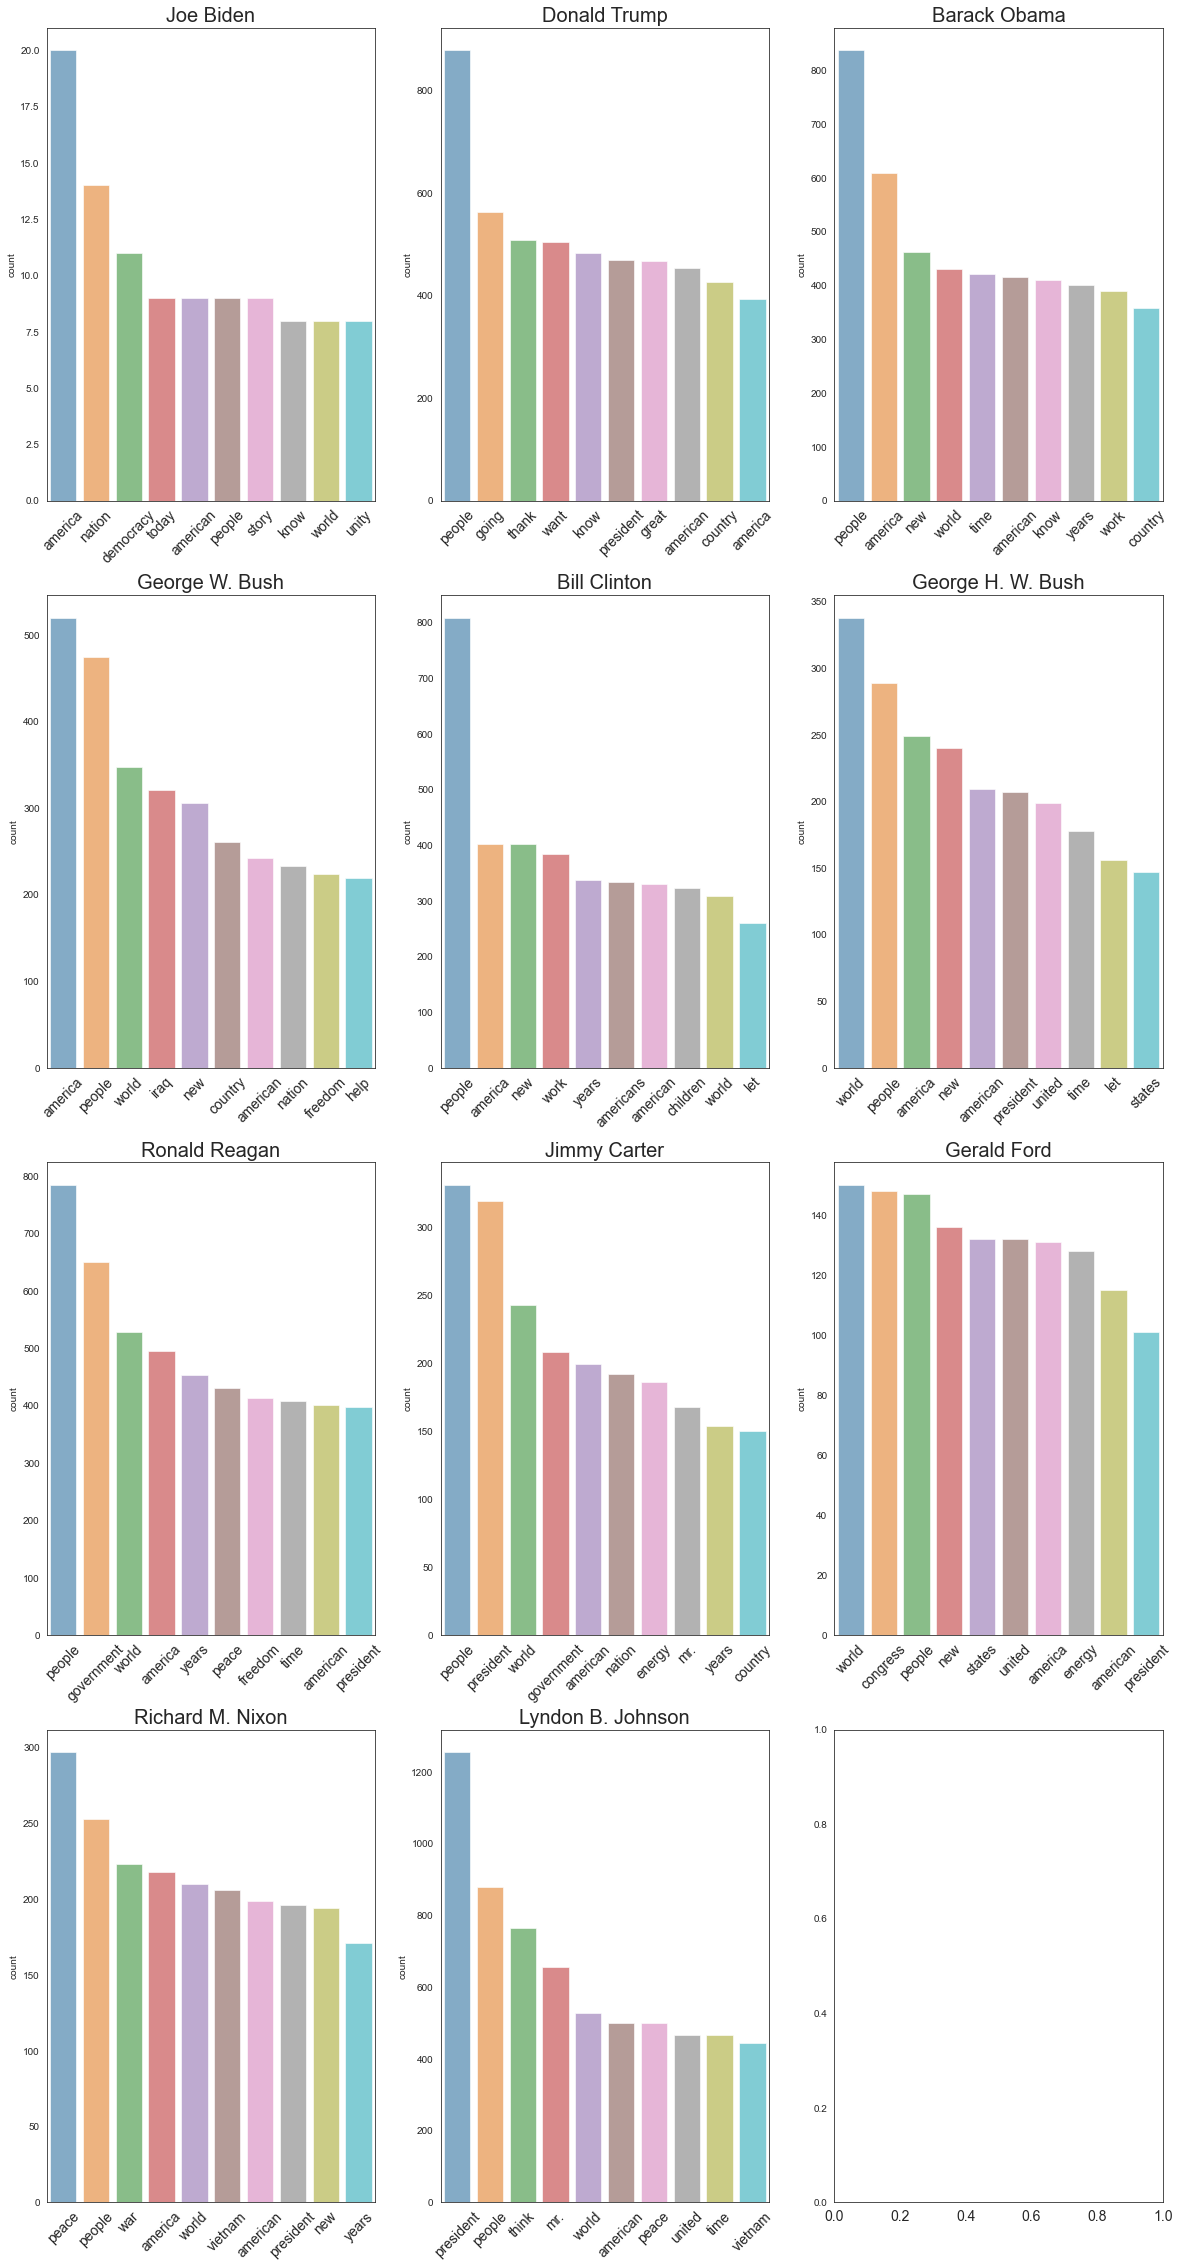

In [97]:
fig, ax = plt.subplots(4, 3, figsize=(20,40))
r = 0
c = 0
for i, president in enumerate(['Joe Biden', 'Donald Trump', 'Barack Obama', 'George W. Bush', 'Bill Clinton', 'George H. W. Bush', 'Ronald Reagan', 'Jimmy Carter', 'Gerald Ford',                               'Richard M. Nixon', 'Lyndon B. Johnson']):
    print(r,c)
    df = wordCounter(president_dict[president])[:10]

    plt.sca(ax[r, c])
    p = sns.barplot(data=df, ax=ax[r, c],
                    x="word", y="count", alpha=.6)
    sns.set_style("white")

    plt.xticks(rotation=45)
    plt.xlabel("")
    ax[r, c].set_title(president)
    plt.rc('axes', titlesize=20)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=14)

    if c < 2:
        c += 1
    elif c >= 2:
        r += 1
        c=0

In [78]:
# Plot the number of unique words used by each president
unique_words = {president: len(set(values)) for president, values in president_dict.items()}


unique_words_df = pd.DataFrame({"President":[president for president in unique_words.keys()], 
                                "unique_words": [unique_words[president] for president in unique_words.keys()],
                                "num_speeches": [number_speeches_dict[president] for president in number_speeches_dict.keys()]})


chart1 = alt.Chart(unique_words_df, title='Unique words used by presidents in speeches').mark_bar().encode(
    x=alt.X('President:N',sort='-y'),
    y='unique_words',
    color=alt.Color('President', legend=None, scale=alt.Scale(scheme='tableau10'))).properties(
    width=400,
    height=500
)

chart2 = alt.Chart(unique_words_df, title='Number of total speeches in corpus').mark_bar().encode(
    x=alt.X('President:N',sort='-y'),
    y='num_speeches',
    color=alt.Color('President', legend=None, scale=alt.Scale(scheme='tableau10'))).properties(
    width=400,
    height=500
)


alt.hconcat(chart1,chart2).configure_axis(
    labelFontSize=20,
    titleFontSize=20)


alt.HConcatChart(...)

In [37]:
speeches["sentiment"] = speeches.Speech.apply(lambda row: SentimentScorer.polarity_scores(row)["compound"])

In [105]:
alt.Chart(speeches.loc[:, ["President", "sentiment"]], title="Sentiment of presidential speeches",
                         height=20, width=200).mark_point(size=100, filled=True).encode(
    x=alt.X('sentiment:Q', axis=alt.Axis(grid=False)),
    y= alt.Y(
        'jitter:Q',
        title=None,
        axis=alt.Axis(values=[0], ticks=False, grid=False, labels=False),
        scale=alt.Scale(),
    ),
    color=alt.Color('President:N', scale=alt.Scale(scheme='tableau10'), legend=None),
    row=alt.Column(
        'President:N',
        sort = speeches.President.unique(),
        header=alt.Header(
            titleOrient='top',
            labelOrient='bottom',
            labelAlign='center',
            labelPadding=10,
        ),title="",
    )).transform_calculate(
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
)

alt.Chart(...)

In [45]:
from spacy import displacy

## Using dependency parsing to see syntactic complexity in presidential speeches

In [46]:
speeches.head()

,speech_name,President,Date,Speech,tokenized_text,normalized_text,tokenized_sents,top_10_words,sentiment
0,january-20-2021-inaugural-address,Joe Biden,"January 20, 2021","Chief Justice Roberts, Vice President Harris, ...","[Chief, Justice, Roberts, Vice, President, Har...","[chief, justice, roberts, vice, president, har...","[[Chief, Justice, Roberts, Vice, President, Ha...",word count 16 america 20 53...,0.9995
1,january-19-2021-farewell-address,Donald Trump,"January 19, 2021","My fellow Americans: Four years ago, we launch...","[My, fellow, Americans, Four, years, ago, we, ...","[fellow, americans, year, ago, launch, great, ...","[[My, fellow, Americans, Four, years, ago, we,...",word count 19 america 24 125 ...,0.9999
2,january-13-2021-statement-about-violence-capitol,Donald Trump,"January 13, 2021","My fellow Americans,I want to speak to you ton...","[My, fellow, Americans, I, want, to, speak, to...","[fellow, americans, want, speak, tonight, trou...","[[My, fellow, Americans, I, want, to, speak, t...",word count 23 violence 7 ...,0.9650
3,january-7-2021-message-after-pro-trump-mob-ove...,Donald Trump,"January 07, 2021",I would like to begin by addressing the heinou...,"[I, would, like, to, begin, by, addressing, th...","[like, begin, address, heinous, attack, unite,...","[[I, would, like, to, begin, by, addressing, t...",word count 24 america 3 41...,0.9966
4,january-6-2021-speech-urging-supporters-go-home,Donald Trump,"January 06, 2021",I know your pain. I know your hurt.We had an e...,"[I, know, your, pain, I, know, your, hurt, We,...","[know, pain, know, hurt, election, steal, land...","[[I, know, your, pain], [I, know, your, hurt],...",word count 8 home 4 0 ...,-0.2407


In [48]:

def get_depth(root):
    """
    Recursively find max depth of the dependency parse of a spacy chunk by starting with its root
    Code adapted from https://stackoverflow.com/questions/35920826/how-to-find-height-for-non-binary-tree
    :param root: spacy.tokens.token.Token
    :return: int, maximum height of sentence's dependency parse tree
    """
    if not list(root.children):
        return 1
    else:
        return 1 + max(get_depth(x) for x in root.children)


# Find the max depth of each sentence dependency tree
def get_tree_depths(df, sentence_col):
    """
    Calculate the max depth of eache sentence dependency tree.
    :param df: pd.DataFrame with sentence column
    :param sentence_col: column name with tokenized sentences
    :return df:
    """

    all_sentences = []
    depths = []
    for sentence in df[sentence_col].values[0]:
        text = ' '.join(sentence)
        doc = nlp(text)
        max_depths = []
        for chunk in doc.noun_chunks:
            max_depths.append(get_depth(chunk.root))
        all_sentences.append(text)

        if not max_depths:
            max_depths.append(0)

        depths.append(max(max_depths))

    depth_tree = pd.DataFrame({"sentence":all_sentences, "max_depth": depths})
    depth_tree.sort_values(by=["max_depth"], ascending=False, inplace=True)

    return depth_tree


In [52]:
depth_df = get_tree_depths(speeches.loc[speeches.President == 'Joe Biden', :], "tokenized_sents")
depth_df.mean().values[0]

2.7432432432432434

In [54]:
complexity = {"president":[], "sentence":[], "max_depth":[], "min_depth":[], "average_depth":[]}
for i, president in enumerate(['Joe Biden', 'Donald Trump', 'Barack Obama', 'George W. Bush', 'Bill Clinton', 'George H. W. Bush', 'Ronald Reagan', 'Jimmy Carter', 'Gerald Ford',                               'Richard M. Nixon', 'Lyndon B. Johnson']):

    depth_df = get_tree_depths(speeches.loc[speeches.President == president, :], "tokenized_sents")
    
    
    complexity['president'].append(president)
    complexity['sentence'].append(depth_df.iloc[0,0])
    complexity['max_depth'].append(depth_df.iloc[0,1])
    complexity['min_depth'].append(depth_df.iloc[-1,1])
    complexity['average_depth'].append(depth_df.mean().values[0])

    print("President:", president)
    print(f"Most complex sentence had a depth of {depth_df.iloc[0,1]}")
    print(depth_df.iloc[0,0])
    print()
    

complexity_df = pd.DataFrame(complexity)


President: Joe Biden
Most complex sentence had a depth of 11
Let us say a silent prayer for those who lost their lives for those they left behind and for our country

President: Donald Trump
Most complex sentence had a depth of 12
This is a republic of proud citizens who are united by our common conviction that America is the greatest nation in all of history

President: Barack Obama
Most complex sentence had a depth of 16
Look at somebody like Madison Little who grew up dealing with some health issues and started wondering what his care would have been like if he lived someplace else and so here at Rutgers he took charge of a student nonprofit and worked with folks in Australia and Cambodia and Uganda to address the AIDS epidemic

President: George W. Bush
Most complex sentence had a depth of 11
We 're standing with dissidents and young democracies providing AIDS medicine to dying patients to bring dying patients back to life and sparing mothers and babies from malaria

President: Bil

In [55]:
complexity_df.sort_values(by='max_depth', ascending=False)

,president,sentence,max_depth,min_depth,average_depth
8,Gerald Ford,From the opportunities which fate and my fello...,22,0,5.171946
5,George H. W. Bush,We would risk the emergence of a world charact...,19,0,4.010152
2,Barack Obama,Look at somebody like Madison Little who grew ...,16,0,3.220963
4,Bill Clinton,In all the work I have done as President every...,16,1,4.327273
6,Ronald Reagan,And she 's still a beacon still a magnet for a...,15,0,3.564593
10,Lyndon B. Johnson,For the future the quest for peace I believe r...,14,0,4.522968
7,Jimmy Carter,Of Vice President Mondale my Cabinet and the h...,13,1,5.128713
9,Richard M. Nixon,It is the best house because it has something ...,13,0,2.915888
1,Donald Trump,This is a republic of proud citizens who are u...,12,0,3.772455
0,Joe Biden,Let us say a silent prayer for those who lost ...,11,0,2.743243


In [72]:
complexity_depth_range = complexity_df.melt(id_vars='president', value_vars=['max_depth', "min_depth", "average_depth"])
complexity_depth_range.columns = ["president", "variable", "depth"]
complexity_depth_range.head()

,president,variable,depth
0,Joe Biden,max_depth,11.0
1,Donald Trump,max_depth,12.0
2,Barack Obama,max_depth,16.0
3,George W. Bush,max_depth,11.0
4,Bill Clinton,max_depth,16.0


In [80]:
alt.Chart(complexity_depth_range, title="Sentence dependency parsing depths",
                           height=400, width=100).mark_point(size=100, filled=True).encode(
    x=alt.X(
        'jitter:Q',
        title=None,
        axis=alt.Axis(values=[0], ticks=False, grid=False, labels=False),
        scale=alt.Scale(),
    ),
    y=alt.Y('depth:Q', axis=alt.Axis(grid=False)),
    shape = alt.Shape("variable:O"),
    color=alt.Color('president:N', scale=alt.Scale(scheme='tableau10'))).transform_calculate(
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
)

alt.Chart(...)

In [49]:
doc = nlp(complexity_df.sort_values(by='depth', ascending=False).iloc[0, 1])
displacy.render(doc, style='dep')